# Philadelphia: a city about to boom?

**Michael Uftring**   
**Indiana University**   
**I590 Data Visualization**   
**Fall, 2017**   


In [2]:
import requests
import json
import prettytable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# code to: decode Months and Dates

In [3]:
code2month = {
    "M01" : "January",
    "M02" : "February",
    "M03" : "March",
    "M04" : "April",
    "M05" : "May",
    "M06" : "June",
    "M07" : "July",
    "M08" : "August",
    "M09" : "September",
    "M10" : "October",
    "M11" : "November",
    "M12" : "December"
}

month2number = {
    "January" : "01",
    "February" : "02",
    "March" : "03",
    "April" : "04",
    "May" : "05",
    "June" : "06",
    "July" : "07",
    "August" : "08",
    "September" : "09",
    "October" : "10",
    "November" : "11",
    "December" : "12"
}

def dateFrom(year, month):
    return "{}/{}".format(year,month2number[month])


# code to: decode the City/Town

In [4]:
code2citytown = {}
citytown2code = {}

file = open("bls-cities-and-towns.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, citytownstate = line.rstrip().split(">", 2)[1].split(" ",2)
    citytown, state = citytownstate.split(",")
    code2citytown[code]=citytown
    citytown2code[citytown]=code
    #print("line: {} code: {} citytownstate: {}, citytown: {}, state: {}".format(count, code, citytownstate, citytown, state))

file.close()

def decodeCityTown(s):
    code = s[3:len(s)-2]
    return code2citytown[code]

import re
def searchDictionary(d, city):
    #print("searching for:", city)
    res = []
    for key in d.keys():
        if re.match(city, key):
            res.append(d[key])
    return res

def findCityTownCode(city):
    return searchDictionary(citytown2code, city)

def trimCityName(city):
    return city.replace(" city","").replace(" County/city","").replace(" town","")

In [5]:
city = "Dallas"
code = findCityTownCode(city)
print("city: {} trim: {} code: {}".format(city, trimCityName(city), code))

city: Dallas trim: Dallas code: ['CT4819000000000']


# code to: decode the State

In [6]:
code2state = {}

file = open("bls-state-codes.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, state = line.rstrip().split(">", 2)[1].split(" ",2)
    code2state[code]=state
    #print("line: {} code: {} state: {}".format(count, code, state))

file.close()

def decodeState(s):
    code = s[5:7]
    return code2state[code]


# code to: decode the Measure

In [7]:
code2measure = {
    "03" : "unemployment-rate",
    "04" : "unemployment",
    "05" : "employment",
    "06" : "labor-force"
}

measure2Code = {
    "unemployment-rate" : "03",
    "unemployment" : "04",
    "employment" : "05",
    "labor-force" : "06"
}

def findMeasureCode(s):
    return measure2Code[s]

def decodeMeasure(s):
    code = s[len(s)-2:]
    return code2measure[code]


# input parameters for data request

In [8]:
cityListGeoRegional = ["Boston", "New York", "Philadelphia", "Baltimore", "Washington city"]
cityListPopSize = ["Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas"]

cityList = cityListGeoRegional + cityListPopSize

startYear = 2008
endYear = 2017

seasonalAdjustment = "no"

measureList = ["labor-force", "employment", "unemployment", "unemployment-rate"]

In [9]:
cityList

['Boston',
 'New York',
 'Philadelphia',
 'Baltimore',
 'Washington city',
 'Phoenix',
 'Philadelphia',
 'San Antonio',
 'San Diego',
 'Dallas']

# construct the BLS Series ID

In [10]:
seriesIDs = []

dataSet = "LA"

if seasonalAdjustment == "yes":
    saCode = "S"
else:
    saCode = "U"

for city in cityList:
    cityCode = findCityTownCode(city)
    for measure in measureList:
        measureCode = findMeasureCode(measure)
        seriesID = "{}{}{}{}".format(dataSet, saCode, cityCode[0], measureCode)
        print("city: {} code: {} measure: {} code: {} seriesID: {}".format(city, cityCode, measure, measureCode, seriesID))
        seriesIDs.append(seriesID)

# an array of strings which represent BLS Series IDs
# seriesID = ['LAUMT423798000000003']
# seriesID = ['LAUCT426000000000003']
# seriesID = ["{}{}{}{}".format(dataSet, saCode, cityCode[0], measureCode)]

city: Boston code: ['CT2507000000000'] measure: labor-force code: 06 seriesID: LAUCT250700000000006
city: Boston code: ['CT2507000000000'] measure: employment code: 05 seriesID: LAUCT250700000000005
city: Boston code: ['CT2507000000000'] measure: unemployment code: 04 seriesID: LAUCT250700000000004
city: Boston code: ['CT2507000000000'] measure: unemployment-rate code: 03 seriesID: LAUCT250700000000003
city: New York code: ['CT3651000000000'] measure: labor-force code: 06 seriesID: LAUCT365100000000006
city: New York code: ['CT3651000000000'] measure: employment code: 05 seriesID: LAUCT365100000000005
city: New York code: ['CT3651000000000'] measure: unemployment code: 04 seriesID: LAUCT365100000000004
city: New York code: ['CT3651000000000'] measure: unemployment-rate code: 03 seriesID: LAUCT365100000000003
city: Philadelphia code: ['CT4260000000000'] measure: labor-force code: 06 seriesID: LAUCT426000000000006
city: Philadelphia code: ['CT4260000000000'] measure: employment code: 05 

In [11]:
print(seriesIDs)

['LAUCT250700000000006', 'LAUCT250700000000005', 'LAUCT250700000000004', 'LAUCT250700000000003', 'LAUCT365100000000006', 'LAUCT365100000000005', 'LAUCT365100000000004', 'LAUCT365100000000003', 'LAUCT426000000000006', 'LAUCT426000000000005', 'LAUCT426000000000004', 'LAUCT426000000000003', 'LAUCT240400000000006', 'LAUCT240400000000005', 'LAUCT240400000000004', 'LAUCT240400000000003', 'LAUCT115000000000006', 'LAUCT115000000000005', 'LAUCT115000000000004', 'LAUCT115000000000003', 'LAUCT045500000000006', 'LAUCT045500000000005', 'LAUCT045500000000004', 'LAUCT045500000000003', 'LAUCT426000000000006', 'LAUCT426000000000005', 'LAUCT426000000000004', 'LAUCT426000000000003', 'LAUCT486500000000006', 'LAUCT486500000000005', 'LAUCT486500000000004', 'LAUCT486500000000003', 'LAUCT066600000000006', 'LAUCT066600000000005', 'LAUCT066600000000004', 'LAUCT066600000000003', 'LAUCT481900000000006', 'LAUCT481900000000005', 'LAUCT481900000000004', 'LAUCT481900000000003']


# build the data request

In [12]:
headers = {'Content-type': 'application/json'}
request = json.dumps({"seriesid": seriesIDs,"startyear":"{}".format(startYear), "endyear":"{}".format(endYear)})

In [13]:
print(request)

{"seriesid": ["LAUCT250700000000006", "LAUCT250700000000005", "LAUCT250700000000004", "LAUCT250700000000003", "LAUCT365100000000006", "LAUCT365100000000005", "LAUCT365100000000004", "LAUCT365100000000003", "LAUCT426000000000006", "LAUCT426000000000005", "LAUCT426000000000004", "LAUCT426000000000003", "LAUCT240400000000006", "LAUCT240400000000005", "LAUCT240400000000004", "LAUCT240400000000003", "LAUCT115000000000006", "LAUCT115000000000005", "LAUCT115000000000004", "LAUCT115000000000003", "LAUCT045500000000006", "LAUCT045500000000005", "LAUCT045500000000004", "LAUCT045500000000003", "LAUCT426000000000006", "LAUCT426000000000005", "LAUCT426000000000004", "LAUCT426000000000003", "LAUCT486500000000006", "LAUCT486500000000005", "LAUCT486500000000004", "LAUCT486500000000003", "LAUCT066600000000006", "LAUCT066600000000005", "LAUCT066600000000004", "LAUCT066600000000003", "LAUCT481900000000006", "LAUCT481900000000005", "LAUCT481900000000004", "LAUCT481900000000003"], "startyear": "2008", "end

# send the request

In [14]:
# get the data using API
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=request, headers=headers)

# extract the JSON data payload from the response

In [15]:
json_data = json.loads(p.text)

# define the resulting dataset columns

In [16]:
colNames = ["seriesid","year","month","period","date","state","city","measure","value","footnotes"]

# extract and process the JSON payload into a *PrettyTable*  and a plain Python array...

In [17]:
data = []
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(colNames)
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        month = code2month[period]
        date = dateFrom(year, month)
        state = decodeState(seriesId)
        city = decodeCityTown(seriesId)
        measure = decodeMeasure(seriesId)
        value = item['value']
        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            row = [seriesId,year,month,period,date,state,city,measure,value,footnotes[0:-1]]
            x.add_row(row)
            data.append(row)

# create a *DataFrame*

In [18]:
data[0:2]

[['LAUCT426000000000003',
  '2017',
  'September',
  'M09',
  '2017/09',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.0',
  'Preliminary.'],
 ['LAUCT426000000000003',
  '2017',
  'August',
  'M08',
  '2017/08',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.7',
  '']]

In [19]:
dfLaborForce = pd.DataFrame(data, columns=colNames)

In [20]:
dfLaborForce.head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
0,LAUCT426000000000003,2017,September,M09,2017/09,Pennsylvania,Philadelphia County/city,unemployment-rate,6.0,Preliminary.
1,LAUCT426000000000003,2017,August,M08,2017/08,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,
2,LAUCT426000000000003,2017,July,M07,2017/07,Pennsylvania,Philadelphia County/city,unemployment-rate,6.9,
3,LAUCT426000000000003,2017,June,M06,2017/06,Pennsylvania,Philadelphia County/city,unemployment-rate,6.4,
4,LAUCT426000000000003,2017,May,M05,2017/05,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,


In [21]:
dfLaborForce[dfLaborForce.month=="July"].head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
2,LAUCT426000000000003,2017,July,M07,2017/07,Pennsylvania,Philadelphia County/city,unemployment-rate,6.9,
14,LAUCT426000000000003,2016,July,M07,2016/07,Pennsylvania,Philadelphia County/city,unemployment-rate,7.6,
26,LAUCT426000000000003,2015,July,M07,2015/07,Pennsylvania,Philadelphia County/city,unemployment-rate,8.0,
38,LAUCT426000000000003,2014,July,M07,2014/07,Pennsylvania,Philadelphia County/city,unemployment-rate,8.9,
50,LAUCT426000000000003,2013,July,M07,2013/07,Pennsylvania,Philadelphia County/city,unemployment-rate,11.0,


In [22]:
dfLaborForceSelect = dfLaborForce[dfLaborForce.month=="July"].copy()

In [23]:
dfLaborForceSelect.drop(['seriesid','month','period','date','footnotes'], axis=1, inplace=True)

In [24]:
dfLaborForceSelect.rename(columns={"year": "Year", "state": "State", "city": "City", "measure": "Measure", "value": "Value"}, inplace=True)

In [25]:
dfLaborForceSelect.head()

,Year,State,City,Measure,Value
2,2017,Pennsylvania,Philadelphia County/city,unemployment-rate,6.9
14,2016,Pennsylvania,Philadelphia County/city,unemployment-rate,7.6
26,2015,Pennsylvania,Philadelphia County/city,unemployment-rate,8.0
38,2014,Pennsylvania,Philadelphia County/city,unemployment-rate,8.9
50,2013,Pennsylvania,Philadelphia County/city,unemployment-rate,11.0


# load the population data

In [26]:
pop1 = pd.read_csv("census-data-2000-2009.csv", sep=",", encoding='latin-1')
pop2 = pd.read_csv("census-data-2010-2016.csv", sep=",", encoding='latin-1')

In [27]:
data1t = pd.melt(pop1, id_vars=["sumlev", "STATE", "COUNTY", "place", "COUSUB", "name", "STATENAME"],
                 var_name="Date", 
                 value_name="Value")

data2t = pd.melt(pop2, id_vars=["SUMLEV", "STATE", "COUNTY", "PLACE", "COUSUB", "CONCIT", "PRIMGEO_FLAG", "FUNCSTAT", "NAME", "STNAME"], 
                 var_name="Date", 
                 value_name="Value")

In [28]:
data1ts = data1t[(data1t.sumlev==162) & (data1t.Date.str.contains("POP_"))].copy()
data2ts = data2t[(data2t.SUMLEV==162) & (data2t.Date.str.contains("POPESTIMATE"))].copy()

In [29]:
data1ts.drop(['sumlev','STATE','COUNTY','place','COUSUB'], axis=1, inplace=True)
data1ts.rename(columns={"name": "City", "STATENAME": "State"}, inplace=True)
data1ts.Date = data1ts.Date.str.replace("POP_", "")

data2ts.drop(['SUMLEV','STATE','COUNTY','PLACE','COUSUB','CONCIT','PRIMGEO_FLAG','FUNCSTAT'], axis=1, inplace=True)
data2ts.rename(columns={"NAME":"City", "STNAME":"State"}, inplace=True)
data2ts.Date = data2ts.Date.str.replace("POPESTIMATE", "")

In [30]:
print("len(data1ts): {} len(data2ts) {} total: {}".format(len(data1ts), len(data2ts), len(data1ts)+len(data2ts)))
frames = [data1ts, data2ts]
dfPopulation = pd.concat(frames)
print("len(dfPopulation): {}".format(len(dfPopulation)))

len(data1ts): 195100 len(data2ts) 136570 total: 331670
len(dfPopulation): 331670


In [31]:
dfPopulation.head()

,City,State,Date,Value
163407,Abbeville city,Alabama,2000,2987
163408,Adamsville city,Alabama,2000,5069
163409,Addison town,Alabama,2000,724
163410,Akron town,Alabama,2000,449
163411,Alabaster city,Alabama,2000,24099


In [32]:
dfPopulation['Measure'] = "population"

In [33]:
dfPopulation.rename(columns={"Date": "Year"}, inplace=True)

In [34]:
dfPopulation.head()

,City,State,Year,Value,Measure
163407,Abbeville city,Alabama,2000,2987,population
163408,Adamsville city,Alabama,2000,5069,population
163409,Addison town,Alabama,2000,724,population
163410,Akron town,Alabama,2000,449,population
163411,Alabaster city,Alabama,2000,24099,population


# merge labor-force and population data

In [35]:
frames = [dfPopulation, dfLaborForceSelect]

In [36]:
df = pd.concat(frames)

In [37]:
df[(df.City == "Boston city") & (df.State == "Massachusetts") & (df.Year >= "2008")]

,City,Measure,State,Value,Year
845280,Boston city,population,Massachusetts,636748,2008
926983,Boston city,population,Massachusetts,645169,2009
191488,Boston city,population,Massachusetts,620701,2010
273073,Boston city,population,Massachusetts,630195,2011
354658,Boston city,population,Massachusetts,641911,2012
436243,Boston city,population,Massachusetts,651090,2013
517828,Boston city,population,Massachusetts,659180,2014
599413,Boston city,population,Massachusetts,665984,2015
680998,Boston city,population,Massachusetts,673184,2016
470,Boston city,unemployment-rate,Massachusetts,4.2,2017


# trim city names

In [38]:
df.City = [trimCityName(city) for city in df.City]

# plot labor-force and population

In [39]:
# city = "Boston"
# state = "Massachusetts"

city = "Philadelphia"
state = "Pennsylvania"

beginYear = "2008"
endYear = "2016"

In [40]:
def getData(measure):
    return df[(df.City == city) & (df.State == state) & (df.Year >= beginYear) & (df.Year <= endYear) & (df.Measure == measure)].sort_values(['Year'])

In [41]:
measure = "labor-force"
lfd = getData(measure)

In [42]:
measure = "population"
pop = getData(measure)

In [43]:
emp = getData("employment")

In [44]:
uem = getData("unemployment")

In [45]:
lfd

,City,Measure,State,Value,Year
461,Philadelphia,labor-force,Pennsylvania,641086,2008
449,Philadelphia,labor-force,Pennsylvania,663457,2009
437,Philadelphia,labor-force,Pennsylvania,696073,2010
425,Philadelphia,labor-force,Pennsylvania,698060,2011
413,Philadelphia,labor-force,Pennsylvania,709570,2012
401,Philadelphia,labor-force,Pennsylvania,705946,2013
389,Philadelphia,labor-force,Pennsylvania,698219,2014
377,Philadelphia,labor-force,Pennsylvania,701763,2015
365,Philadelphia,labor-force,Pennsylvania,715091,2016


In [46]:
pop

,City,Measure,State,Value,Year
879498,Philadelphia,population,Pennsylvania,1540351,2008
961201,Philadelphia,population,Pennsylvania,1547297,2009
225482,Philadelphia,population,Pennsylvania,1528427,2010
307067,Philadelphia,population,Pennsylvania,1539022,2011
388652,Philadelphia,population,Pennsylvania,1550379,2012
470237,Philadelphia,population,Pennsylvania,1555868,2013
551822,Philadelphia,population,Pennsylvania,1560609,2014
633407,Philadelphia,population,Pennsylvania,1564964,2015
714992,Philadelphia,population,Pennsylvania,1567872,2016


In [47]:
emp

,City,Measure,State,Value,Year
344,Philadelphia,employment,Pennsylvania,593590,2008
332,Philadelphia,employment,Pennsylvania,595015,2009
320,Philadelphia,employment,Pennsylvania,618211,2010
308,Philadelphia,employment,Pennsylvania,616582,2011
296,Philadelphia,employment,Pennsylvania,624624,2012
284,Philadelphia,employment,Pennsylvania,628376,2013
272,Philadelphia,employment,Pennsylvania,635793,2014
260,Philadelphia,employment,Pennsylvania,645338,2015
248,Philadelphia,employment,Pennsylvania,660808,2016


In [48]:
uem

,City,Measure,State,Value,Year
227,Philadelphia,unemployment,Pennsylvania,47496,2008
215,Philadelphia,unemployment,Pennsylvania,68442,2009
203,Philadelphia,unemployment,Pennsylvania,77862,2010
191,Philadelphia,unemployment,Pennsylvania,81478,2011
179,Philadelphia,unemployment,Pennsylvania,84946,2012
167,Philadelphia,unemployment,Pennsylvania,77570,2013
155,Philadelphia,unemployment,Pennsylvania,62426,2014
143,Philadelphia,unemployment,Pennsylvania,56425,2015
131,Philadelphia,unemployment,Pennsylvania,54283,2016


In [49]:
ratio = (lfd.Value.values.astype("int")/pop.Value.values.astype("int"))*100.0

In [50]:
ratio

array([ 41.61947504,  42.87845191,  45.54178904,  45.35737631,
        45.76751878,  45.37312934,  44.74016233,  44.84211777,  45.60901655])

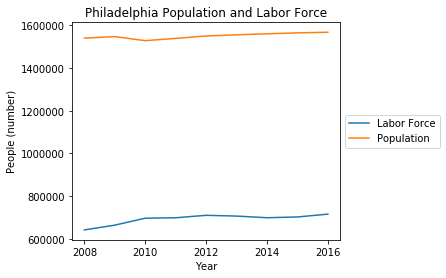

In [51]:
fig = plt.figure()
ax = plt.subplot(111)

y1 = lfd.Value.values.astype("int")
y2 = pop.Value.values.astype("int")
x = lfd.Year.values.astype("int")
#plt.plot(x, y1, label="Labor Force", x, y2, label="Population")
ax.plot(x, y1, label="Labor Force")
ax.plot(x, y2, label="Population")
plt.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("{} Population and Labor Force".format(city))
ax.set_ylabel("People (number)")
ax.set_xlabel("Year")
plt.show()

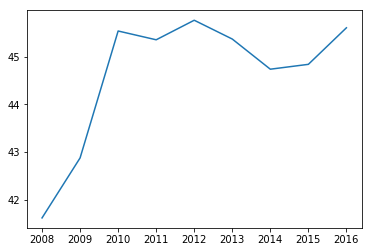

In [52]:
plt.plot(x, ratio)

In [53]:
measure = "unemployment-rate"
uer = getData(measure)

In [54]:
uer

,City,Measure,State,Value,Year
110,Philadelphia,unemployment-rate,Pennsylvania,7.4,2008
98,Philadelphia,unemployment-rate,Pennsylvania,10.3,2009
86,Philadelphia,unemployment-rate,Pennsylvania,11.2,2010
74,Philadelphia,unemployment-rate,Pennsylvania,11.7,2011
62,Philadelphia,unemployment-rate,Pennsylvania,12.0,2012
50,Philadelphia,unemployment-rate,Pennsylvania,11.0,2013
38,Philadelphia,unemployment-rate,Pennsylvania,8.9,2014
26,Philadelphia,unemployment-rate,Pennsylvania,8.0,2015
14,Philadelphia,unemployment-rate,Pennsylvania,7.6,2016


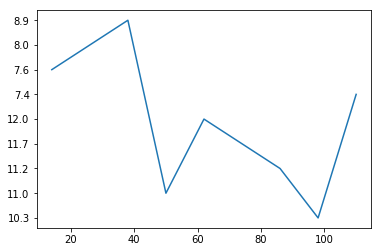

In [55]:
plt.plot(uer.Value)

# population changes

In [56]:
pop.Value.values

array([1540351, 1547297, 1528427, 1539022, 1550379, 1555868, 1560609,
       1564964, 1567872], dtype=object)

In [57]:
pop.Value.values[1:]

array([1547297, 1528427, 1539022, 1550379, 1555868, 1560609, 1564964,
       1567872], dtype=object)

In [58]:
pop.Value.values[:-1]

array([1540351, 1547297, 1528427, 1539022, 1550379, 1555868, 1560609,
       1564964], dtype=object)

In [59]:
deltas = pop.Value.values[1:] - pop.Value.values[:-1]

In [60]:
deltas

array([6946, -18870, 10595, 11357, 5489, 4741, 4355, 2908], dtype=object)

In [61]:
(deltas/pop.Value.values[:-1])*100.0

array([0.4509361827271836, -1.2195460858516498, 0.6931963384577738,
       0.7379361698533224, 0.3540424631654583, 0.30471736676890326,
       0.27905772682331065, 0.1858189709156249], dtype=object)

In [62]:
pop.Year.values[1:].astype("int")

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

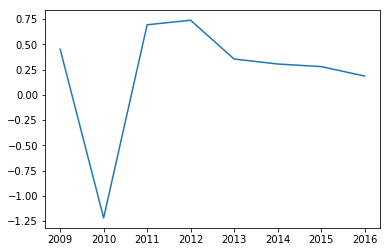

In [63]:
x = pop.Year.values[1:].astype("int")
y = (deltas/pop.Value.values[:-1])*100.0
plt.plot(x, y)

# labor force changes

In [64]:
lfd.Value.values.astype("int")

array([641086, 663457, 696073, 698060, 709570, 705946, 698219, 701763,
       715091])

In [65]:
deltas = lfd.Value.values[1:].astype("int") - lfd.Value.values[:-1].astype("int")

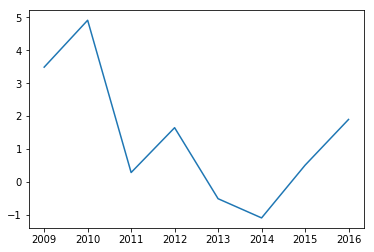

In [66]:
x = lfd.Year.values[1:].astype("int")
y = (deltas/lfd.Value.values[:-1].astype("int"))*100.0
plt.plot(x, y)

# can we plot both?

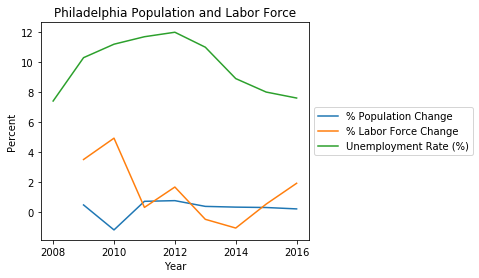

In [67]:
fig = plt.figure()
ax = plt.subplot(111)

popVals = pop.Value.values.astype("int")
lfdVals = lfd.Value.values.astype("int")

# population
x1 = pop.Year.values[1:].astype("int")
y1 = ((popVals[1:] - popVals[:-1])/popVals[:-1])*100.0

# labor force
x2 = lfd.Year.values[1:].astype("int")
y2 = ((lfdVals[1:] - lfdVals[:-1])/lfdVals[:-1])*100.0

# unemployment rate
x3 = uer.Year.values.astype("int")
y3 = uer.Value.values.astype("float")

ax.plot(x1, y1, label="% Population Change")
ax.plot(x2, y2, label="% Labor Force Change")
ax.plot(x3, y3, label="Unemployment Rate (%)")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("{} Population and Labor Force".format(city))
ax.set_ylabel("Percent")
ax.set_xlabel("Year")
plt.show()

In [68]:
pop.Year.values.astype("int")

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [69]:
popVals

array([1540351, 1547297, 1528427, 1539022, 1550379, 1555868, 1560609,
       1564964, 1567872])

In [70]:
lfdVals

array([641086, 663457, 696073, 698060, 709570, 705946, 698219, 701763,
       715091])

In [71]:
popVals[1:] - popVals[:-1]

array([  6946, -18870,  10595,  11357,   5489,   4741,   4355,   2908])

In [72]:
lfdVals[1:] - lfdVals[:-1]

array([22371, 32616,  1987, 11510, -3624, -7727,  3544, 13328])

In [73]:
summaryTable = pd.DataFrame(columns=["Year", "Population", "PopulationChange", "LaborForce", "LaborForceChange"])

In [74]:
summaryTable['Year'] = pop.Year.values.astype("int")
summaryTable['Population'] = popVals
popChange = [0]
for p in popVals[1:] - popVals[:-1]:
    popChange.append(p )
len(popChange)
summaryTable['PopulationChange'] = popChange
summaryTable['LaborForce'] = lfdVals
lfdChange = [0]
for l in lfdVals[1:] - lfdVals[:-1]:
    lfdChange.append(l)
summaryTable['LaborForceChange'] = lfdChange
summaryTable['UnemploymentRate'] = uer.Value.values
summaryTable['Employment'] = emp.Value.values
summaryTable['Unemployment'] = uem.Value.values


In [75]:
summaryTable

,Year,Population,PopulationChange,LaborForce,LaborForceChange,UnemploymentRate,Employment,Unemployment
0,2008,1540351,0,641086,0,7.4,593590,47496
1,2009,1547297,6946,663457,22371,10.3,595015,68442
2,2010,1528427,-18870,696073,32616,11.2,618211,77862
3,2011,1539022,10595,698060,1987,11.7,616582,81478
4,2012,1550379,11357,709570,11510,12.0,624624,84946
5,2013,1555868,5489,705946,-3624,11.0,628376,77570
6,2014,1560609,4741,698219,-7727,8.9,635793,62426
7,2015,1564964,4355,701763,3544,8.0,645338,56425
8,2016,1567872,2908,715091,13328,7.6,660808,54283


In [76]:
(715091-641086)/641086

0.11543693045862802

In [77]:
660808+54283

715091

In [78]:
emp.Value.values.astype("int")[1:]-emp.Value.values.astype("int")[:-1]

array([ 1425, 23196, -1629,  8042,  3752,  7417,  9545, 15470])

In [79]:
uem.Value.values.astype("int")[1:]-uem.Value.values.astype("int")[:-1]

array([ 20946,   9420,   3616,   3468,  -7376, -15144,  -6001,  -2142])

In [80]:
def delta(a,b):
    return ((b-a)/a)*100.0

In [81]:
delta(47496, 54283)

14.289624389422267

In [82]:
delta(593590, 660808)

11.323977829815192

# plot ratio and unemployment rate

In [83]:
#fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex=True)
#ax1.plot(x, ratio)
#ax1.set_title("Ratio of Labor Force to Population")
#ax2.plot(x, uer.Value.values.astype("float"))
#ax2.set_title("Unemployment Rate")

# plot per city (1) population and labor force, (2) ratio and unemployment rate

In [84]:
#cityListGeoRegional = ["Boston", "New York", "Philadelphia", "Baltimore", "Washington city"]
#cityListPopSize = ["Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas"]

cityListGeoRegionalX = ["Boston", "New York", "Philadelphia", "Baltimore", "Washington"]
stateListGeoRegionalX = ["Massachusetts", "New York", "Pennsylvania", "Maryland", "District of Columbia"]
cityListPopSizeX = ["Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas"]
stateListPopSizeX = ["Arizona", "Pennsylvania", "Texas", "California", "Texas"]

In [85]:
cityListX = cityListGeoRegionalX
stateListX = stateListGeoRegionalX

beginYearX = "2008"
endYearX = "2016"

cityStateList = []
for i in range(len(cityListX)):
    cityStateList.append((cityListX[i], stateListX[i]))

In [86]:
cityStateList

[('Boston', 'Massachusetts'),
 ('New York', 'New York'),
 ('Philadelphia', 'Pennsylvania'),
 ('Baltimore', 'Maryland'),
 ('Washington', 'District of Columbia')]

In [87]:
frames = []
for city, state in cityStateList:
    dfs = df[(df.City==city) & (df.State==state) & (df.Year>=beginYearX) & (df.Year<=endYearX)].sort_values(['Measure', 'Year'])
    print(dfs)
    frames.append(dfs)

          City            Measure          State   Value  Year
812     Boston         employment  Massachusetts  309163  2008
800     Boston         employment  Massachusetts  303159  2009
788     Boston         employment  Massachusetts  314539  2010
776     Boston         employment  Massachusetts  319585  2011
764     Boston         employment  Massachusetts  325693  2012
752     Boston         employment  Massachusetts  329650  2013
740     Boston         employment  Massachusetts  339755  2014
728     Boston         employment  Massachusetts  348817  2015
716     Boston         employment  Massachusetts  355265  2016
929     Boston        labor-force  Massachusetts  328248  2008
917     Boston        labor-force  Massachusetts  330383  2009
905     Boston        labor-force  Massachusetts  342167  2010
893     Boston        labor-force  Massachusetts  343798  2011
881     Boston        labor-force  Massachusetts  348666  2012
869     Boston        labor-force  Massachusetts  35371

              City            Measure                 State   Value  Year
2333    Washington         employment  District of Columbia  317143  2008
2321    Washington         employment  District of Columbia  311807  2009
2309    Washington         employment  District of Columbia  322602  2010
2297    Washington         employment  District of Columbia  319754  2011
2285    Washington         employment  District of Columbia  338754  2012
2273    Washington         employment  District of Columbia  346385  2013
2261    Washington         employment  District of Columbia  353065  2014
2249    Washington         employment  District of Columbia  366043  2015
2237    Washington         employment  District of Columbia  372221  2016
2918    Washington        labor-force  District of Columbia  339374  2008
2906    Washington        labor-force  District of Columbia  344905  2009
2894    Washington        labor-force  District of Columbia  356243  2010
2882    Washington        labor-force 

In [88]:
frames

[          City            Measure          State   Value  Year
 812     Boston         employment  Massachusetts  309163  2008
 800     Boston         employment  Massachusetts  303159  2009
 788     Boston         employment  Massachusetts  314539  2010
 776     Boston         employment  Massachusetts  319585  2011
 764     Boston         employment  Massachusetts  325693  2012
 752     Boston         employment  Massachusetts  329650  2013
 740     Boston         employment  Massachusetts  339755  2014
 728     Boston         employment  Massachusetts  348817  2015
 716     Boston         employment  Massachusetts  355265  2016
 929     Boston        labor-force  Massachusetts  328248  2008
 917     Boston        labor-force  Massachusetts  330383  2009
 905     Boston        labor-force  Massachusetts  342167  2010
 893     Boston        labor-force  Massachusetts  343798  2011
 881     Boston        labor-force  Massachusetts  348666  2012
 869     Boston        labor-force  Mass

In [89]:
dfx = pd.DataFrame(columns=["City","Measure","State","Value","Year"])

In [90]:
dfx = pd.concat(frames)

In [91]:
dfx

,City,Measure,State,Value,Year
812,Boston,employment,Massachusetts,309163,2008
800,Boston,employment,Massachusetts,303159,2009
788,Boston,employment,Massachusetts,314539,2010
776,Boston,employment,Massachusetts,319585,2011
764,Boston,employment,Massachusetts,325693,2012
752,Boston,employment,Massachusetts,329650,2013
740,Boston,employment,Massachusetts,339755,2014
728,Boston,employment,Massachusetts,348817,2015
716,Boston,employment,Massachusetts,355265,2016
929,Boston,labor-force,Massachusetts,328248,2008


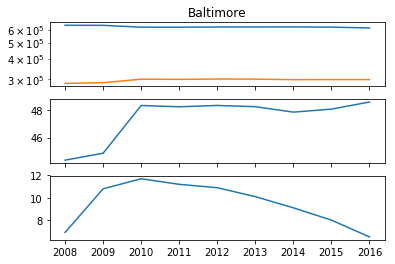

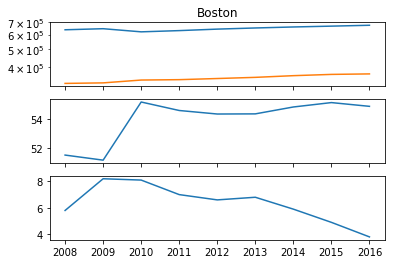

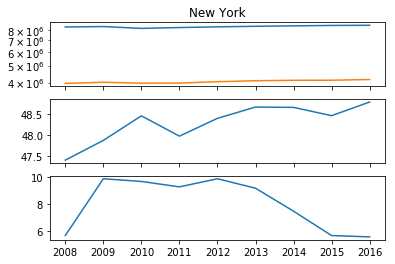

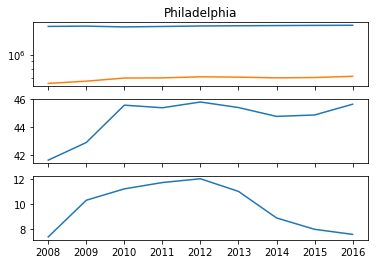

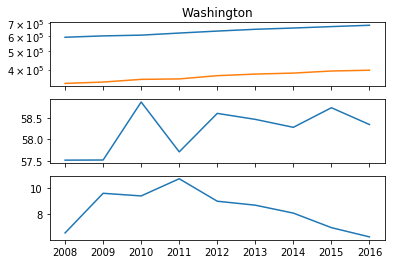

In [92]:
for key, grp in dfx.groupby(['City']): 
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex=True)
    srt = grp.sort_values(['Measure','Year'])
    x = srt[srt.Measure=="population"].Year.values.astype("int")
    y1 = srt[srt.Measure=="population"].Value.values.astype("int")
    y2 = srt[srt.Measure=="labor-force"].Value.values.astype("int")
    ax1.set_title(key)
    ax1.plot(x, y1, x, y2)
    ax1.set_yscale("log")
    ratios = (srt[srt.Measure=="labor-force"].Value.values.astype("int")/
              srt[srt.Measure=="population"].Value.values.astype("int"))*100.0
    ax2.plot(x, ratios)
    y = srt[grp.Measure=="unemployment-rate"].Value.values.astype("float")
    ax3.plot(x, y)

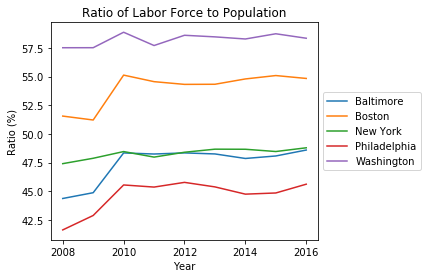

In [96]:
fig, ax = plt.subplots()

for key, grp in dfx.groupby(['City']):
    srt = grp.sort_values(['Year','Measure'])
    years = srt[srt.Measure=="labor-force"].Year.values.astype("int")
    lfnData = srt[srt.Measure=="labor-force"].Value.values.astype("int")
    popData = srt[srt.Measure=="population"].Value.values.astype("int")
    ratios = (lfnData/popData)*100.0
    #print(key)
    #print(srt)
    #print("Years:", years)
    #print("Labor Force:", lfnData)
    #print("Population:", popData)
    #print("Ratios:", ratios)
    ax.plot(years, ratios, label=key)
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("Ratio of Labor Force to Population")
ax.set_ylabel("Ratio (%)")
ax.set_xlabel("Year")
plt.show()

In [97]:
#import pandas as pd
#import statsmodels.api as sm
#import matplotlib.pylab as plt
#from pandas.tools.plotting import andrews_curves
#
#fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)
#
#for key, grp in df.groupby(['City']): 
#    #ax2.plot(grp['date'], grp['value'], label = "{}".format(key))
#    print("key: {}, grp: {}".format(key, type(grp)))
#    x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in grp.date.values])
#    y = list(grp.value.values)
#    ax2.plot(x, y, label=key)
#
#plt.legend(loc='right')    
#plt.show()

In [98]:
df.head()

,City,Measure,State,Value,Year
163407,Abbeville,population,Alabama,2987,2000
163408,Adamsville,population,Alabama,5069,2000
163409,Addison,population,Alabama,724,2000
163410,Akron,population,Alabama,449,2000
163411,Alabaster,population,Alabama,24099,2000


In [107]:
for key, grp in dfx.groupby(['City']):
    earliest = float(grp.sort_values(['Year']).head(1).Value.values[0])
    latest   = float(grp.sort_values(['Year']).tail(1).Value.values[0])
    print("city: {0:20s}\tearliest: {1}\t latest: {2}\tdelta: {3:-5.2f}".format(key,earliest,latest,latest-earliest))


city: Baltimore           	earliest: 263512.0	 latest: 6.5	delta: -263505.50
city: Boston              	earliest: 309163.0	 latest: 3.8	delta: -309159.20
city: New York            	earliest: 3730392.0	 latest: 5.6	delta: -3730386.40
city: Philadelphia        	earliest: 593590.0	 latest: 7.6	delta: -593582.40
city: Washington          	earliest: 317143.0	 latest: 6.3	delta: -317136.70


[Text(0,0,'Baltimore'),
 Text(0,0,'Boston'),
 Text(0,0,'New York'),
 Text(0,0,'Philadelphia'),
 Text(0,0,'Washington')]

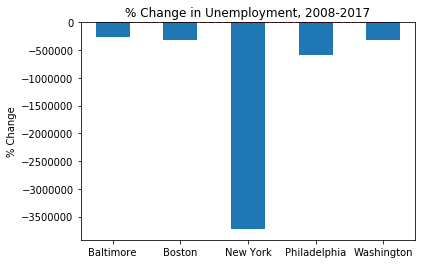

In [108]:
fig, ax = plt.subplots()

deltas = []
cities = []

for key, grp in dfx.groupby(['City']):
    earliest = float(grp.sort_values(['Year']).head(1).Value.values[0])
    latest   = float(grp.sort_values(['Year']).tail(1).Value.values[0])
    delta = latest-earliest
    #print("city: {0:20s}\tearliest: {1}\t latest: {2}\tdelta: {3:-5.2f}".format(key,earliest,latest,delta))
    cities.append(trimCityName(key))
    deltas.append(delta)

ind = np.arange(len(deltas))
width = 0.5

ax.plot(ind, [0,0,0,0,0], "r--")
ax.bar(ind, deltas, width)

ax.set_ylabel('% Change')
ax.set_title('% Change in Unemployment, 2008-2017')
ax.set_xticks(ind)
ax.set_xticklabels((cities))


# load the national unemployment data
file created from data presented at: http://www.ncsl.org/research/labor-and-employment/national-employment-monthly-update.aspx

In [109]:
file = open("bls-national-unemployment.raw", "r")
data = []

count = 0
for line in file.readlines():
    count += 1
    line2 = re.sub(' +',' ', line.rstrip())
    fields = [f.strip() for f in line2.split("\t")]
    #print(count,fields)
    data.append(fields)
    
file.close()

In [110]:
data2 = []
for i in range(1, len(data)):
    #print(i, data[i])
    row = data[i]
    year = row[0]
    for j in range(1,len(row)):
        month = "{0:02}".format(j)
        #print(i,j,year,month,row[j])
        row2 = ["national-unemployment","{}/{}".format(year,month),row[j]]
        data2.append(row2)

In [111]:
df2 = pd.DataFrame(data2, columns=["measure","date","value"])
df2 = df2.sort_values('date')

In [112]:
df2.head()

,measure,date,value
105,national-unemployment,2008/01,4.9
106,national-unemployment,2008/02,4.8
107,national-unemployment,2008/03,5.1
108,national-unemployment,2008/04,5.0
109,national-unemployment,2008/05,5.5


# plot a city's data
(this is based on the Matplotlib example here: https://matplotlib.org/examples/api/date_demo.html )

In [115]:
df.head()

,City,Measure,State,Value,Year
163407,Abbeville,population,Alabama,2987,2000
163408,Adamsville,population,Alabama,5069,2000
163409,Addison,population,Alabama,724,2000
163410,Akron,population,Alabama,449,2000
163411,Alabaster,population,Alabama,24099,2000


In [114]:
"""
================
Date tick labels
================

Show how to make date plots in matplotlib using date tick locators and
formatters.  See major_minor_demo1.py for more information on
controlling major and minor ticks

All matplotlib date plotting is done by converting date instances into
days since the 0001-01-01 UTC.  The conversion, tick locating and
formatting is done behind the scenes so this is most transparent to
you.  The dates module provides several converter functions date2num
and num2date

"""
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

cityName = "Philadelphia County/city"
cityData = df[df.City==cityName]
x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in cityData.date.values])
y = list(cityData.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("{} Unemployment, 2008-2017".format(trimCityName(cityName)))
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend([trimCityName(cityName)])
plt.show()

AttributeError: 'DataFrame' object has no attribute 'date'

# plot the national data

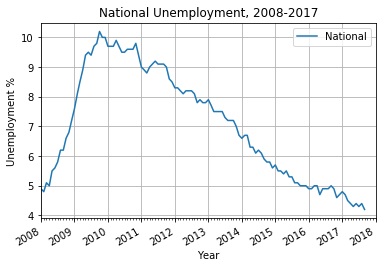

In [115]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y = list(df2.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("National Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(['National'])
plt.show()

# plot both national and city data

In [116]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x1 = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y1 = list(df2.value.values)

cityName = "Philadelphia County/city"
cityData = df[df.city==cityName]
x2 = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in cityData.date.values])
y2 = list(cityData.value.values)

fig, ax = plt.subplots()
ax.plot(x1, y1, x2, y2)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(['National',trimCityName(cityName)])
plt.show()

AttributeError: 'DataFrame' object has no attribute 'city'

# plot the national and all the fetched cities data

KeyError: 'city'

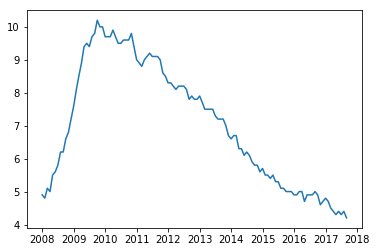

In [117]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()

# national data
x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y = list(df2.value.values)
ax.plot(x, y, label="National")

for key, grp in df.groupby(['city']): 
    print("key: {}, grp: {}".format(key, type(grp)))
    x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in grp.date.values])
    y = list(grp.value.values)
    ax.plot(x, y, label=trimCityName(key))
    
# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1.0), ncol=1)
plt.show()

# plot a lot of things together!

KeyError: 'city'

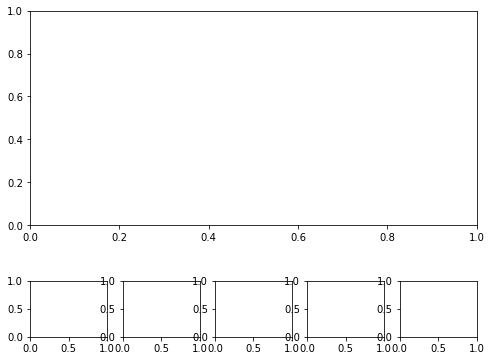

In [118]:
plt.figure(figsize=(8, 6))
axs = []
ax0 = plt.subplot2grid((6,5), (0,0), colspan=10, rowspan=4)
axs.append(plt.subplot2grid((5,5), (4,0), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,1), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,2), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,3), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,4), colspan=1))

deltas = []
cities = []

for key, grp in df.groupby(['city']):
    earliest = float(grp.sort_values(['date']).head(1).value.values[0])
    latest   = float(grp.sort_values(['date']).tail(1).value.values[0])
    delta = latest-earliest
    print("city: {0:20s} earliest: {1} latest: {2} delta: {3:-5.2f}".format(trimCityName(key),earliest,latest,delta))
    cities.append(trimCityName(key))
    deltas.append(delta)

ind = np.arange(len(deltas))
width = 0.75

ax0.plot(ind, [0,0,0,0,0], "r--")
ax0.bar(ind, deltas, width)

ax0.set_ylabel('% Change')
ax0.set_title('% Change in Unemployment, 2008-2017')
ax0.set_xticks(ind)
ax0.set_xticklabels((cities))



years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# national data
nat_x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
nat_y = list(df2.value.values)

count = -1
for key, grp in df.groupby(['city']): 
    count += 1
    #print("key: {}, grp: {}".format(key, type(grp)))
    x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in grp.date.values])
    y = list(grp.value.values)
    ax = axs[count]
    ax.plot(nat_x, nat_y, label='National')
    ax.plot(x, y, label=key)
    ax.set_ylim(0,12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if count >= 0:
        xtl = ax.get_xticklabels()
        for i in range(1,len(xtl)-2):
            tl = xtl[i]
            tl.set_visible(False)
    if count > 0:
        for tl in ax.get_yticklabels():
            tl.set_visible(False)
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    # set x-axis min and max
    datemin = datetime.date(min(x).year, 1, 1)
    datemax = datetime.date(max(x).year, 1, 1)
    ax.set_xlim(datemin, datemax)
    # set a y-axis label
    if count == 0:
        ax.set_ylabel("Unemployment %")
